# Capstone 1 Project Overview (Predicting Mutual Fund Flows)


### What is the problem you want to solve?

I want to try and predict fund flows (ie. new money being invested into a mutual fund) over the subsequent month or quarter. I want to predict this as (1) total new dollars going in/out of a fund, (2) percent fund flows, (3) a categorical predictor if the fund will receive greater fund flows than it did over the prior quarter, and (4) excess fund flows above what a similar mutual fund would get.

### Who is your client and why do they care about this problem?

My client would be any mutual fund family (ie. Vanguard, Janus, Invesco, etc…). They would have an interest in this problem because it would help them to better target their resources to funds that are going to generate the greatest profits for the fund family.

### What data are you using and how will you acquire it?

I will utilize data from the Center for Research in Security Prices (CRSP) for stock level data, the Center for Research in Security Prices Mutual Fund Database (CRSP MF) for mutual fund characteristics, and Morningstar (MS) for mutual fund manager characteristics. I will access the CRSP databases through the Wharton Research Data Services (WRDS) interface and Morningstar directly through the Morningstar database.

### How will you solve this problem?

I will utilize regression analysis and prediction to determine which fund, manager, objective, fund family, and overall market characteristics explain future fund flows.

### What are your deliverables?

This jupyter notebook will serve as my deliverable. Markdown cells will contain a description of what I am doing.

_______________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________

# Purpose:

The purpose of this project is to examine the determinants of mutual fund inflows (ie. new money flowing into a mutual fund) over monthly observations. Sirri and Tufano (1998) show that the primary driver of fund flows is performance, and that mutual fund investors chase returns (ie. they invest in mutual funds with superiod performance, even though past performance does not predict future performance).

In [1]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:20,.4f}'.format

Import the first file, tna (total net assets) that contains dates, mutual fund size, and mutual fund returns. 

I clean up errors in the data by removing 'R' and 'T' values. 

I then remove observations with size less than 0 and returns below -100%, both are not possible and are therefore errors in the data.

In [2]:
#import returns and size file

tna = pd.read_csv('mret_tna.csv',parse_dates=['caldt'],na_values=['R','T'])
tna = tna[tna['mtna'] >= 0]
tna = tna[tna['mret'] > -1]


The two variables of interest
    1. mtna = monthly total net assets (mutual fund size)
    2. mret = monthly returns. 

In [3]:
tna[['mtna','mret']].describe()

,mtna,mret
count,"4,720,137.0000","4,720,137.0000"
mean,538.2051,0.0050
std,"3,118.5113",0.0413
min,0.0000,-0.9802
25%,4.9000,-0.0074
50%,36.5000,0.0042
75%,210.4000,0.0213
max,"306,670.6000",10.8966


Import the second file for this analysis.
    1. crsp_fundno = mutual fund share class
    2. caldt = monthly observation date
    3. per_cash = percent of cash held by the mutual fund share class
    4. crsp_cl_grp = mutual fund portfolio (the ID used to aggregate the multiple shareclasses)
    5. exp_ratio = expense ratio as a decimal
    6. crsp_obj_cd = mutual fund objective code

In [4]:
#import mf characteristics file 

mf_char = pd.read_csv('fund_char.csv',parse_dates=['caldt'])
mf_char = mf_char.dropna(subset=['crsp_cl_grp'])
mf_char['crsp_cl_grp'] = mf_char['crsp_cl_grp'].astype(np.int64)
mf_char.head()

,summary_period2,crsp_fundno,caldt,per_cash,crsp_portno,crsp_cl_grp,ncusip,exp_ratio,crsp_obj_cd
0,AQ,105,2004-12-31,nan,"1,000,880.0000",2000026,028837102,0.0285,EF
1,AQ,105,2005-12-30,0.0000,"1,000,880.0000",2000026,028837102,0.0272,EF
2,AQ,105,2006-12-29,0.0000,"1,000,880.0000",2000026,028837102,0.0258,EF
3,AQ,105,2007-12-31,0.0000,"1,000,880.0000",2000026,028837102,0.0259,EF
4,AQ,105,2008-12-31,0.8400,"1,000,880.0000",2000026,028837102,0.0256,EF


drop unused data (that comes with the dataset as a default setting) to clean dataset for merging

In [5]:
#drop extra columns not needed for analysis

mf_char2 = mf_char.drop(['summary_period2','ncusip','crsp_portno'], axis=1)
mf_char2.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,2004-12-31,nan,2000026,0.0285,EF
1,105,2005-12-30,0.0000,2000026,0.0272,EF
2,105,2006-12-29,0.0000,2000026,0.0258,EF
3,105,2007-12-31,0.0000,2000026,0.0259,EF
4,105,2008-12-31,0.8400,2000026,0.0256,EF


Create a ym variable that drops the day from the date. 

Create a y variable that drops the day and month from date. 

YM allows for easier merging by avoiding instances such as 2004-12-31 trying to merge with 2004-12-30. 

The y date will allow for easier merging as well when we combine the mf_char file which is at yearly frequency with the tna file which is monthly. 

In both cases the obvservation is for December 2004, but happened to occur on different days.

In [6]:
#create ym variables for analysis at month level
tna['ym'] = pd.to_datetime(tna['caldt']).dt.to_period('M')
tna['y'] = pd.to_datetime(tna['caldt']).dt.to_period('Y')
tna_ym = tna
tna_ym.head()

,caldt,crsp_fundno,mtna,mret,ym,y
48,2004-01-30,105,51.5000,0.0361,2004-01,2004
49,2004-02-27,105,51.5000,-0.0028,2004-02,2004
50,2004-03-31,105,52.1000,-0.0038,2004-03,2004
51,2004-04-30,105,49.7000,-0.0483,2004-04,2004
52,2004-05-28,105,50.5000,0.0249,2004-05,2004


repeat the same process as above with the second file so that both contain the ym and y variables for merging

In [7]:
mf_char2['y'] = pd.to_datetime(mf_char2['caldt']).dt.to_period('Y')
mf_ym = mf_char2.drop('caldt', axis=1)
mf_ym.head()

,crsp_fundno,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd,y
0,105,nan,2000026,0.0285,EF,2004
1,105,0.0000,2000026,0.0272,EF,2005
2,105,0.0000,2000026,0.0258,EF,2006
3,105,0.0000,2000026,0.0259,EF,2007
4,105,0.8400,2000026,0.0256,EF,2008


Merge the mutual fund returns and size with the other mutual fund characteristics by fund shareclass (crsp_fundno) and y. 

Require all observations to occur in the tna_ym file.

In [8]:
#merge tna_ym and mf_ym by fundno & ym - how = inner (ie. must have data in both sets)
tna_ret = pd.merge(tna_ym,mf_ym,on=['crsp_fundno','y'],how='left').dropna(subset=['crsp_cl_grp'])
tna_ret['crsp_cl_grp'] = tna_ret['crsp_cl_grp'].astype(np.int64)

tna_ret.sort_values(by=['crsp_cl_grp']).head()

,caldt,crsp_fundno,mtna,mret,ym,y,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,2004-01-30,105,51.5000,0.0361,2004-01,2004,nan,2000026,0.0285,EF
3548749,2016-02-29,45769,26.7000,0.0023,2016-02,2016,0.7300,2000026,0.0138,EF
3548750,2016-03-31,45769,28.3000,0.0708,2016-03,2016,0.7300,2000026,0.0138,EF
3548751,2016-04-29,45769,27.9000,0.0021,2016-04,2016,0.7300,2000026,0.0138,EF
3548752,2016-05-31,45769,27.6000,0.0142,2016-05,2016,0.7300,2000026,0.0138,EF


Sort files by mutual fund portfolio (crsp_cl_grp) and date (ym) to begin aggregating data up from the shareclass level to the portfolio level.

Fill in NaN valules of expense ratio and cash with 0, and forward fill .

Forward fill missing crsp_obj_cd observations by mutual fund portfolio.

In [9]:
tna_ret2 = tna_ret.copy()
tna_ret2.sort_values(['crsp_cl_grp','ym'],inplace=True)

tna_ret2['per_cash'].fillna(0, inplace=True)
tna_ret2['exp_ratio'].fillna(0, inplace=True)

tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].fillna(method='ffill')  
tna_ret2.drop('crsp_obj_cd', axis=1, inplace=True)
#tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].apply(lambda x: x.ffill())

tna_ret2.head()

,caldt,crsp_fundno,mtna,mret,ym,y,per_cash,crsp_cl_grp,exp_ratio,obj
0,2004-01-30,105,51.5000,0.0361,2004-01,2004,0.0000,2000026,0.0285,EF
1,2004-02-27,105,51.5000,-0.0028,2004-02,2004,0.0000,2000026,0.0285,EF
2,2004-03-31,105,52.1000,-0.0038,2004-03,2004,0.0000,2000026,0.0285,EF
3,2004-04-30,105,49.7000,-0.0483,2004-04,2004,0.0000,2000026,0.0285,EF
4,2004-05-28,105,50.5000,0.0249,2004-05,2004,0.0000,2000026,0.0285,EF


Calculate total mutual fund portfolio size each month as the total mtna across all shareclasses within a portfolio.

In [10]:
portno_size = tna_ret2.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'mtna':'sum'})
portno_size.rename(columns={'mtna':'portno_tna'},inplace=True) 
portno_size.head()

,crsp_cl_grp,ym,portno_tna
0,2000026,2004-01,51.5000
1,2000026,2004-02,51.5000
2,2000026,2004-03,52.1000
3,2000026,2004-04,49.7000
4,2000026,2004-05,50.5000


Merge the portfolio tna with the original shareclass data to allow for a weighted average of mutual fund characeristics.

In [11]:
#merge portfolio tna with fundno data to allow for weight calculations
port1 = pd.merge(tna_ret2,portno_size,on=['crsp_cl_grp','ym'],how='inner')
port1.head()

,caldt,crsp_fundno,mtna,mret,ym,y,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna
0,2004-01-30,105,51.5000,0.0361,2004-01,2004,0.0000,2000026,0.0285,EF,51.5000
1,2004-02-27,105,51.5000,-0.0028,2004-02,2004,0.0000,2000026,0.0285,EF,51.5000
2,2004-03-31,105,52.1000,-0.0038,2004-03,2004,0.0000,2000026,0.0285,EF,52.1000
3,2004-04-30,105,49.7000,-0.0483,2004-04,2004,0.0000,2000026,0.0285,EF,49.7000
4,2004-05-28,105,50.5000,0.0249,2004-05,2004,0.0000,2000026,0.0285,EF,50.5000


calculate what weight each shareclass equals within the mutual fund portfolio, then calculate the shareclass weighted values of cash, expense ratios, and returns.

drop observations where returns are greater than 100% and where portfolio_tna is less than 5 million USD (Evans, 2010).

In [12]:
#calculate weights and weight * vars
port1['wgt'] = port1['mtna'] / port1['portno_tna']
port1['port_cash'] = port1['per_cash'] * port1['wgt']
port1['port_exp'] = port1['exp_ratio'] * port1['wgt']
port1['port_ret'] = port1['mret'] * port1['wgt']
port1 = port1[port1['port_ret'] < 1]
port1 = port1[port1['portno_tna'] > 5]
port1.head()

,caldt,crsp_fundno,mtna,mret,ym,y,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna,wgt,port_cash,port_exp,port_ret
0,2004-01-30,105,51.5000,0.0361,2004-01,2004,0.0000,2000026,0.0285,EF,51.5000,1.0000,0.0000,0.0285,0.0361
1,2004-02-27,105,51.5000,-0.0028,2004-02,2004,0.0000,2000026,0.0285,EF,51.5000,1.0000,0.0000,0.0285,-0.0028
2,2004-03-31,105,52.1000,-0.0038,2004-03,2004,0.0000,2000026,0.0285,EF,52.1000,1.0000,0.0000,0.0285,-0.0038
3,2004-04-30,105,49.7000,-0.0483,2004-04,2004,0.0000,2000026,0.0285,EF,49.7000,1.0000,0.0000,0.0285,-0.0483
4,2004-05-28,105,50.5000,0.0249,2004-05,2004,0.0000,2000026,0.0285,EF,50.5000,1.0000,0.0000,0.0285,0.0249


sum the weight * variable measures created in the prior step. 

aggregate them across each portfolio ym observations. 

These become the portfolio characteristics created from each of the individual shareclass observations.

In [13]:
port2 = port1.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'port_cash':'sum','port_exp':'sum','port_ret':'sum'})
port2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret
0,2000026,2004-01,0.0000,0.0285,0.0361
1,2000026,2004-02,0.0000,0.0285,-0.0028
2,2000026,2004-03,0.0000,0.0285,-0.0038
3,2000026,2004-04,0.0000,0.0285,-0.0483
4,2000026,2004-05,0.0000,0.0285,0.0249


keep only the necessary variables.

keep only the first observation for each mutual fund / month observation (ie. drop share classes)

merge the portfolio variables for cash, expense ratio, and return with the file containing mutual fund objective and portfolio tna.

In [14]:
port3 = port1[['crsp_cl_grp','ym','obj','portno_tna']]
port4 = port3.groupby(['crsp_cl_grp','ym']).cumcount()==0
port5 = port3[port4]

port6 = pd.merge(port2,port5,on=['crsp_cl_grp','ym'],how='inner')
port6.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna
0,2000026,2004-01,0.0000,0.0285,0.0361,EF,51.5000
1,2000026,2004-02,0.0000,0.0285,-0.0028,EF,51.5000
2,2000026,2004-03,0.0000,0.0285,-0.0038,EF,52.1000
3,2000026,2004-04,0.0000,0.0285,-0.0483,EF,49.7000
4,2000026,2004-05,0.0000,0.0285,0.0249,EF,50.5000


Repeat the aggregation process for each mutual fund investment objective. The focus in on calculating the objective size aggregated across all mutual funds within an objective and then determining the objective size and performance.

In [15]:
obj1 = port6.groupby(['obj','ym'],as_index=False).agg({'portno_tna':'sum'})
obj1.rename(columns={'portno_tna':'obj_tna'},inplace=True)
obj1.head()

,obj,ym,obj_tna
0,EDCI,2004-01,"13,757.4000"
1,EDCI,2004-02,"14,014.3000"
2,EDCI,2004-03,"13,900.1000"
3,EDCI,2004-04,"13,320.6000"
4,EDCI,2004-05,"13,071.9000"


merge objective tna with portfolio data to allow for weight calculations

In [16]:
obj2 = pd.merge(port6,obj1,on=['obj','ym'],how='inner')
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna
0,2000026,2004-01,0.0000,0.0285,0.0361,EF,51.5000,"399,311.4000"
1,2000271,2004-01,0.0000,0.0076,0.0131,EF,"1,057.8000","399,311.4000"
2,2000476,2004-01,31.5500,0.0234,0.0282,EF,21.1000,"399,311.4000"
3,2000486,2004-01,7.8600,0.0213,0.0278,EF,190.6000,"399,311.4000"
4,2000500,2004-01,6.5600,0.0242,0.0142,EF,5.1000,"399,311.4000"


calculate weights and weight * vars

In [17]:
obj2['obj_wgt'] = obj2['portno_tna'] / obj2['obj_tna']
obj2['obj_wgt_ret'] = obj2['port_ret'] * obj2['obj_wgt']
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_wgt,obj_wgt_ret
0,2000026,2004-01,0.0000,0.0285,0.0361,EF,51.5000,"399,311.4000",0.0001,0.0000
1,2000271,2004-01,0.0000,0.0076,0.0131,EF,"1,057.8000","399,311.4000",0.0026,0.0000
2,2000476,2004-01,31.5500,0.0234,0.0282,EF,21.1000,"399,311.4000",0.0001,0.0000
3,2000486,2004-01,7.8600,0.0213,0.0278,EF,190.6000,"399,311.4000",0.0005,0.0000
4,2000500,2004-01,6.5600,0.0242,0.0142,EF,5.1000,"399,311.4000",0.0000,0.0000


After aggregating to the objective level, calculate the prior months objective performance (ie. lagged 1 month performance).

In [18]:
obj3 = obj2.groupby(['obj','ym'],as_index=False).agg({'obj_wgt_ret':'sum'})
obj3.rename(columns={'obj_wgt_ret':'obj_ret'},inplace=True)

obj3['lag_obj_ret'] = obj3.groupby('obj')['obj_ret'].shift()
obj3.dropna(subset=['lag_obj_ret'],inplace=True)

obj3.head()

,obj,ym,obj_ret,lag_obj_ret
1,EDCI,2004-02,0.0061,0.0490
2,EDCI,2004-03,0.0024,0.0061
3,EDCI,2004-04,-0.0447,0.0024
4,EDCI,2004-05,0.0026,-0.0447
5,EDCI,2004-06,0.0373,0.0026


merge the aggregated objective data with the fund level observation objective data by objective and ym.

In [19]:
obj4 = pd.merge(obj2,obj3,on=['obj','ym'],how='left')
obj4 = obj4.drop(['obj_wgt','obj_wgt_ret'], axis=1)
obj4.dropna(subset=['lag_obj_ret'],inplace=True)
obj4.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret
391,2000026,2004-02,0.0000,0.0285,-0.0028,EF,51.5000,"417,179.4000",0.0235,0.0207
392,2000271,2004-02,0.0000,0.0076,0.0252,EF,"1,085.0000","417,179.4000",0.0235,0.0207
393,2000476,2004-02,31.5500,0.0234,0.0154,EF,23.5000,"417,179.4000",0.0235,0.0207
394,2000486,2004-02,7.8600,0.0214,0.0200,EF,195.7000,"417,179.4000",0.0235,0.0207
395,2000500,2004-02,6.5600,0.0247,0.0105,EF,7.6000,"417,179.4000",0.0235,0.0207


calculate the variable of interest, mutual fund percentage flows. this is a measure of how much new money enters a mutual fund over the course of a month after accounting for the performance of the fund.

ie. if a mutual fund is 10 this month and 20 next month while having returns of 40% over the month, the fund grew by 10, but 4 of that is due to the returns earned by the fund, so the new fund flows amount to 6.

In [20]:
#calculate fund flows as [tna(t) - [tna(t-1) * 1+port_ret] ]/ portno_tna(t-1)

flow = obj4.copy()
flow.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow['l_port_tna'] = flow.groupby('crsp_cl_grp')['portno_tna'].shift()
flow['flow'] = (flow['portno_tna'] - flow['l_port_tna'] * (1 + flow['port_ret'])) / flow['l_port_tna']
flow.dropna(subset=['flow'],inplace=True)
flow.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow
789,2000026,2004-03,0.0000,0.0285,-0.0038,EF,52.1000,"424,878.1000",0.0033,0.0235,51.5000,0.0154
1187,2000026,2004-04,0.0000,0.0285,-0.0483,EF,49.7000,"418,434.9000",-0.0298,0.0033,52.1000,0.0023
1586,2000026,2004-05,0.0000,0.0285,0.0249,EF,50.5000,"423,751.5000",0.0031,-0.0298,49.7000,-0.0088
1988,2000026,2004-06,0.0000,0.0285,0.0243,EF,52.1000,"434,728.7000",0.0180,0.0031,50.5000,0.0074
2390,2000026,2004-07,0.0000,0.0285,-0.0721,EF,47.9000,"424,582.5000",-0.0322,0.0180,52.1000,-0.0085


drop mutual funds not considered domestic equity (ie. 'ED' objective codes). this is standard practice in the literature when examining mutual funds - we focus on a sample of US based mutual funds that invest in a diversified portfolio of US based stocks.

In [21]:
#retain only ED mutual funds
flow2 = flow.copy()

flow2['obj_2'] = flow2['obj'].str.slice(0,2)

#flow2['obj_2'] = flow2['obj'].astype(str).str[:2]
flow2 = flow2[flow2['obj_2'] == 'ED']

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2
121148,2000035,2004-03,0.8300,0.0114,-0.0169,EDYG,376.9000,"1,091,302.2000",-0.0097,0.0123,381.7000,0.0043,ED
122141,2000035,2004-04,0.8300,0.0114,-0.0186,EDYG,372.9000,"1,069,863.9000",-0.0207,-0.0097,376.9000,0.0080,ED
123142,2000035,2004-05,0.8300,0.0114,0.0122,EDYG,374.8000,"1,086,445.6000",0.0158,-0.0207,372.9000,-0.0071,ED
124148,2000035,2004-06,0.8300,0.0114,0.0144,EDYG,381.8000,"1,115,217.1000",0.0190,0.0158,374.8000,0.0043,ED
125156,2000035,2004-07,0.8300,0.0114,-0.0427,EDYG,365.3000,"1,060,193.2000",-0.0484,0.0190,381.8000,-0.0006,ED


create a measure of lagged monthly returns and drop t = 0 returns.

In [22]:
flow2.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow2['lag_ret'] = flow2.groupby('crsp_cl_grp')['port_ret'].shift()
flow2.dropna(subset=['lag_ret'],inplace=True)
flow2.drop(['port_ret','obj_ret'],axis=1,inplace=True)

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,obj,portno_tna,obj_tna,lag_obj_ret,l_port_tna,flow,obj_2,lag_ret
122141,2000035,2004-04,0.8300,0.0114,EDYG,372.9000,"1,069,863.9000",-0.0097,376.9000,0.0080,ED,-0.0169
123142,2000035,2004-05,0.8300,0.0114,EDYG,374.8000,"1,086,445.6000",-0.0207,372.9000,-0.0071,ED,-0.0186
124148,2000035,2004-06,0.8300,0.0114,EDYG,381.8000,"1,115,217.1000",0.0158,374.8000,0.0043,ED,0.0122
125156,2000035,2004-07,0.8300,0.0114,EDYG,365.3000,"1,060,193.2000",0.0190,381.8000,-0.0006,ED,0.0144
126162,2000035,2004-08,0.8300,0.0114,EDYG,363.5000,"1,054,243.9000",-0.0484,365.3000,-0.0044,ED,-0.0427


clean any outlier observations. if fund flows greater than 500% and if fund flows less than 100% then delete observations. Flows gt 500% is a judgement call, flows less than 100% imply you lost more than 100% of your value.

In [23]:
#create descriptive tables and figures

#general descriptive statistics of variables

flow2 = flow2[flow2['flow'] < 5]
flow2 = flow2[flow2['flow'] > -1]
    
print(flow2.info())
flow2.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656310 entries, 122141 to 1435350
Data columns (total 12 columns):
crsp_cl_grp    656310 non-null int64
ym             656310 non-null object
port_cash      656310 non-null float64
port_exp       656310 non-null float64
obj            656310 non-null object
portno_tna     656310 non-null float64
obj_tna        656310 non-null float64
lag_obj_ret    656310 non-null float64
l_port_tna     656310 non-null float64
flow           656310 non-null float64
obj_2          656310 non-null object
lag_ret        656310 non-null float64
dtypes: float64(8), int64(1), object(3)
memory usage: 65.1+ MB
None


,crsp_cl_grp,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret,l_port_tna,flow,lag_ret
count,"656,310.0000","656,310.0000","656,310.0000","656,310.0000","656,310.0000","656,310.0000","656,310.0000","656,310.0000","656,310.0000"
mean,"2,009,512.7380",4.9758,-0.6832,"1,367.8341","991,152.2539",0.0075,"1,356.9775",0.0110,0.0071
std,"7,238.5175",20.8274,7.5177,"7,451.2729","822,307.7433",0.0443,"7,358.1118",0.1500,0.0515
min,"2,000,035.0000",-668.9200,-99.0000,5.0000,"1,600.1000",-0.3050,5.0000,-0.9998,-0.8394
25%,"2,004,591.0000",0.0600,0.0024,54.9000,"269,138.5000",-0.0153,54.3000,-0.0138,-0.0160
50%,"2,008,510.0000",1.2300,0.0094,210.5000,"760,571.8000",0.0114,208.9000,-0.0026,0.0103
75%,"2,012,689.0000",3.6800,0.0127,800.7000,"1,610,563.8000",0.0326,794.9000,0.0130,0.0340
max,"2,061,827.0000",614.3700,0.0889,"662,577.0000","2,897,052.5000",0.3119,"657,015.3000",4.9887,0.9665


examine the data visually to see if anything looks out of place before deciding what else, if anyting, to do with outliers.

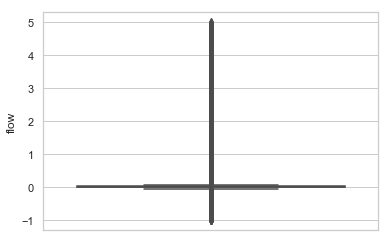

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style='whitegrid')

_ = sns.boxplot(y=flow2['flow'])
plt.show()

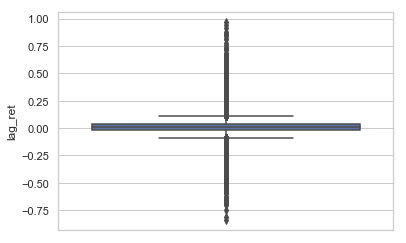

In [25]:
_ = sns.boxplot(y=flow2['lag_ret'])
plt.show()

start some exploratory analysis by looking at correlations between variables. The expectation is that flows will be strongly correlated with current and prior month portfolio returns.

In [26]:
flow2.corr()

,crsp_cl_grp,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret,l_port_tna,flow,lag_ret
crsp_cl_grp,1.0000,0.0460,-0.0298,-0.0455,0.0915,0.0163,-0.0462,0.0637,0.0087
port_cash,0.0460,1.0000,0.0114,-0.0264,-0.1271,-0.0502,-0.0265,0.0370,-0.0538
port_exp,-0.0298,0.0114,1.0000,-0.0242,-0.0964,-0.0031,-0.0239,-0.0037,-0.0006
portno_tna,-0.0455,-0.0264,-0.0242,1.0000,0.0517,0.0066,0.9987,-0.0084,0.0075
obj_tna,0.0915,-0.1271,-0.0964,0.0517,1.0000,0.0511,0.0516,-0.0204,0.0364
lag_obj_ret,0.0163,-0.0502,-0.0031,0.0066,0.0511,1.0000,0.0060,0.0089,0.8530
l_port_tna,-0.0462,-0.0265,-0.0239,0.9987,0.0516,0.0060,1.0000,-0.0128,0.0069
flow,0.0637,0.0370,-0.0037,-0.0084,-0.0204,0.0089,-0.0128,1.0000,0.0165
lag_ret,0.0087,-0.0538,-0.0006,0.0075,0.0364,0.8530,0.0069,0.0165,1.0000


graph the relationship between lag returns and objective lag returns with fund flows.

C:\Users\jstar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Lag Rets')

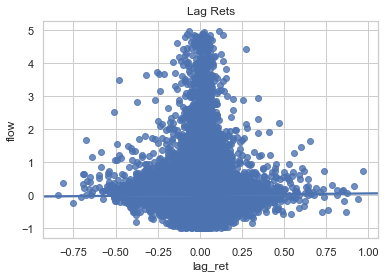

In [27]:
sns.regplot(x='lag_ret',y='flow',data=flow2).set_title('Lag Rets')

Text(0.5, 1.0, 'Lag Obj Rets')

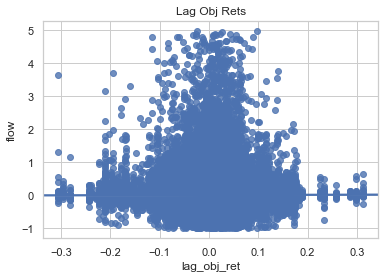

In [28]:
sns.regplot(x='lag_obj_ret',y='flow',data=flow2).set_title('Lag Obj Rets')

explore the plots using subplots. these are not that informative, but i found it good practice.

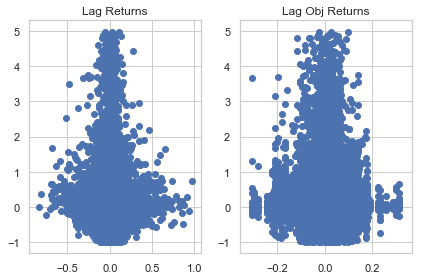

In [29]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.scatter(x='lag_ret',y='flow',data=flow2)
plt.title('Lag Returns')
plt.subplot(1,2,2)
plt.scatter(x='lag_obj_ret',y='flow',data=flow2)
plt.title('Lag Obj Returns')

plt.tight_layout()
plt.show()

the relationship between past performance and fund flows should be positive, with the top performing funds experiencing the benefit of new money. the idea is that as a fund performs well and reports that outperformance, investors observe this and decide to invest in these funds. 

I rank funds each month into 10 groups by fund performance. within each of the ten groups I calculate the average fund flows. 

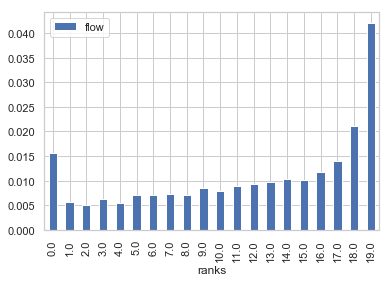

In [30]:
#RANKS AND AVERAGE FLOW

flow3 = flow2.copy()
flow3['ranks'] = flow3.groupby('ym')['lag_ret'].transform(pd.qcut, 20, labels=False)
#flow3.groupby(['ranks']).agg({'port_ret':'mean'})
flow3.groupby(['ranks']).agg({'flow':'mean'}).plot(kind='bar')



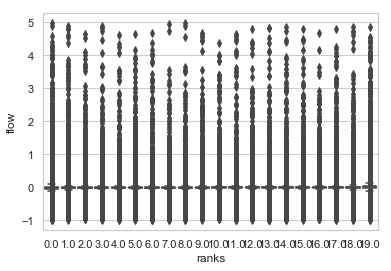

In [31]:
sns.boxplot(x='ranks',y='flow',data=flow3)


The results up to this point indicate that investors observe positive performance in mutual funds and invest in those funds. This is consistent with investors trying to move money into outperforming mutual funds.


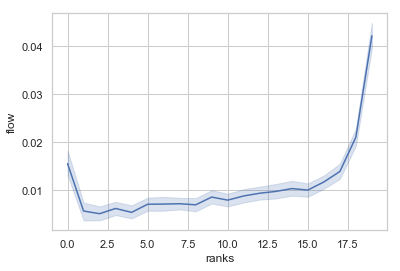

In [32]:
sns.lineplot(x='ranks',y='flow',data=flow3)

For the machine learning portion of this project I plan on implementing both regression and classification methodologies. 
A. Regression 
    1. Basic linear regression to get a baseline of what the relationship looks like.
    2. RandomForest Regressor - revise the GridSearch with additional hyperparameters
    3. Gradient Boosted
    4. Lasso or Ridge Regression for interpretation of coefficients
B. Classification - I will create an identifier variable that takes on a value of one if a mutual fund earns inflows in the top 5% of funds in a month. 
    1. RandomForest
    2. Gradient Boosted
C. Dimension Reduction with PCA?

In [33]:
#I multiply flow by 100 to convert from decimal to percent so that regression coefficients are large enough to interpret.
flow3['flow'] = flow3['flow']*100

I start with a linear regression model and examine four variations.
    1. I examine mutual fund variables
    2. I examine mutual fund variables with year/month and objective fixed effects
    3. I examine mutual fund and objective variables
    4. I examine mutual fund and objective variables with year/month and objective fixed effects
    
The results confirm the univariate descriptive statistics above - investors chance past performance.

In [34]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

info_dict = {'R-squared':lambda x: "{:.2f}".format(x.rsquared),
            'N-obs': lambda x: "{0:d}".format(int(x.nobs))}

lm_1 = ols('flow ~ lag_ret + port_cash + port_exp + portno_tna',flow3).fit()
lm_2 = ols('flow ~ lag_ret + port_cash + port_exp + portno_tna + C(ym) + C(obj)',flow3).fit()
lm_3 = ols('flow ~ lag_ret + port_cash + port_exp + portno_tna + obj_tna + lag_obj_ret',flow3).fit()
lm_4 = ols('flow ~ lag_ret + port_cash + port_exp + portno_tna + obj_tna + lag_obj_ret + C(ym) + C(obj)',flow3).fit()

#for line in lm_1.summary().as_text().split('\n'):
#    if not line.startswith('C':
#        print(line)

#for above, how do I suppress 'C('

results_table = summary_col(results=[lm_1,lm_2,lm_3,lm_4],
                           stars = True,
                           model_names = ['Fund','Fund+FE','Obj','Obj+FE'],
                           info_dict = info_dict,
                           regressor_order=['const','port_ret','lag_ret','port_cash','port_exp','portno_tna',
                                            'obj_tna','obj_ret','lag_obj_ret'])
results_table
                            

,Fund,Fund+FE,Obj,Obj+FE
lag_ret,5.4145***,8.5240***,9.8705***,9.5410***
,(0.3600),(0.5533),(0.6889),(0.6904)
port_cash,0.0273***,0.0099***,0.0258***,0.0098***
,(0.0009),(0.0011),(0.0009),(0.0011)
port_exp,-0.0086***,-0.0073***,-0.0118***,-0.0066***
,(0.0025),(0.0025),(0.0025),(0.0025)
portno_tna,-0.0000***,-0.0000***,-0.0000***,-0.0000***
,(0.0000),(0.0000),(0.0000),(0.0000)
obj_tna,,,-0.0000***,0.0000***
,,,(0.0000),(0.0000)


I create multiple files for later use
    1. X contains all continuous X variables
    2. X_full contains all continuous and string variables
    3. X_d contains all continuous variables and a set of dummy variables for each of the string variables
    
    4. y contains my variable for flow

In [35]:
X = flow3[['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret']]
X_full = flow3[['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret','ym','obj']]
X_d = pd.get_dummies(X_full, columns=['ym','obj'])

y = flow3[['flow']]

Implement another version of linear regression using sklearn and linear_model.LinearRegression(). This model is 'ok' but it does not provide things such as t-statistics or standard errors for the coefficient estimates.

In [36]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

reg.fit(X_d,y)
y_pred = reg.predict(X_d)

results = pd.DataFrame(reg.coef_.tolist(),columns=X_d.columns)
print('R-sq:',reg.score(X_d,y))
results[['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret']]

R-sq: 0.0061353117812211755


,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,9.5410,0.0098,-0.0065,-0.0000,0.0000,-2.8093


Implement a train_test_split approach to the data to ensure the model works as anticipated.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_d,y,test_size=.3,random_state=321)

reg = linear_model.LinearRegression()

reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

print('training score:',reg.score(X_train,y_train))
print('test score:',reg.score(X_test,y_test))

results = pd.DataFrame(reg.coef_.tolist(),columns=X_test.columns)
results[['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret']]


training score: 0.005369775863079962
test score: 0.005657231633815596


,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,6.6211,0.0084,-0.0057,-0.0000,0.0000,0.0980


We observe such different magnitudes across variables. Some are in the millions of dollars, others are percents, and some are as decimals. I standardize all variables to mean 0, std 1 to allow for a better comparison of coefficients.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_full,y,test_size=.3,random_state=321)

Xtrain_scaled = pd.DataFrame(scaler.fit_transform(X_train.drop(['obj','ym'],axis=1)),
                        columns=['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret'])
train_dum_vars = X_train[['obj','ym']]
Xtrain_con = pd.concat([Xtrain_scaled.reset_index(drop=True), train_dum_vars.reset_index(drop=True)], axis=1)
Xtrain_con_d = pd.get_dummies(Xtrain_con, columns=['ym','obj'])

Xtest_scaled = pd.DataFrame(scaler.transform(X_test.drop(['obj','ym'],axis=1)),
                        columns=['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret'])
test_dum_vars = X_test[['obj','ym']]
Xtest_con = pd.concat([Xtest_scaled.reset_index(drop=True), test_dum_vars.reset_index(drop=True)], axis=1)
Xtest_con_d = pd.get_dummies(Xtest_con, columns=['ym','obj'])


reg = linear_model.LinearRegression()

reg.fit(Xtrain_con_d,y_train)
y_pred = reg.predict(Xtest_con_d)

print('training score:',reg.score(Xtrain_con_d,y_train))
print('test score:',reg.score(Xtest_con_d,y_test))

results = pd.DataFrame(reg.coef_.tolist(),columns=Xtest_con_d.columns)
results[['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret']]

training score: 0.005866168201777322
test score: 0.006208247993149673


,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,0.3401,0.1774,-0.0437,-0.0853,0.5255,0.0046


In all cases of the linear regression run above, we observe that investors reach most strongly to prior mutual fund performance. A one stardard deviation increase in lag returns increases mutual fund flow by ~50% over the next period.

I try to implement a lasso regression for practice and because it will allow me to still interpret the variables.

Grid scores for all models based on CV:

0.00178 (+/-0.00099) for {'alpha': 0.01, 'max_iter': 100}
0.00178 (+/-0.00099) for {'alpha': 0.01, 'max_iter': 1000}
0.00178 (+/-0.00099) for {'alpha': 0.01, 'max_iter': 10000}
0.00157 (+/-0.00077) for {'alpha': 0.1, 'max_iter': 100}
0.00157 (+/-0.00077) for {'alpha': 0.1, 'max_iter': 1000}
0.00157 (+/-0.00077) for {'alpha': 0.1, 'max_iter': 10000}
0.00007 (+/-0.00012) for {'alpha': 0.5, 'max_iter': 100}
0.00007 (+/-0.00012) for {'alpha': 0.5, 'max_iter': 1000}
0.00007 (+/-0.00012) for {'alpha': 0.5, 'max_iter': 10000}
-0.00000 (+/-0.00001) for {'alpha': 1, 'max_iter': 100}
-0.00000 (+/-0.00001) for {'alpha': 1, 'max_iter': 1000}
-0.00000 (+/-0.00001) for {'alpha': 1, 'max_iter': 10000}
-0.00000 (+/-0.00001) for {'alpha': 10, 'max_iter': 100}
-0.00000 (+/-0.00001) for {'alpha': 10, 'max_iter': 1000}
-0.00000 (+/-0.00001) for {'alpha': 10, 'max_iter': 10000}

Best parameters set found on train: {'alpha': 0.01, 'max_iter': 100}

Best model validat

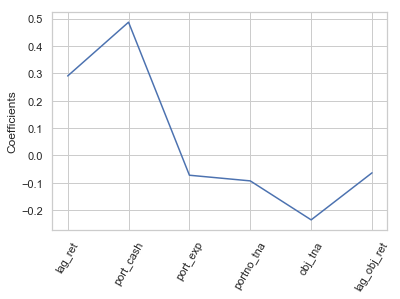

In [39]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

l_params = {'alpha':[.01, .1, .5, 1, 10],'max_iter':[100,1000,10000]}

lasso = linear_model.Lasso(random_state = 123)
clf = GridSearchCV(lasso,l_params,cv=5)
clf.fit(Xtrain_scaled, y_train['flow'].values)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xtest_scaled,y_test['flow'].values))

#best_model = clf.best_estimator_
y_pred = best_model.predict(Xtest_scaled)
best_model.score(Xtest_scaled,y_test)

print('\n',list(zip(best_model.coef_,Xtest_scaled)))

lasso_coefs = best_model.coef_
_ = plt.plot(range(len(Xtest_scaled.columns)), lasso_coefs)
_ = plt.xticks(range(len(Xtest_scaled.columns)), Xtest_scaled.columns, rotation = 60)
_ = plt.ylabel('Coefficients')
plt.show()

###recursive feature elimination in scikit learn (RFE)

In [40]:
lasso_results = pd.DataFrame(best_model.coef_).transpose()
lasso_results.columns=['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret']
lasso_results

,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,0.2901,0.4867,-0.0727,-0.0934,-0.2359,-0.0639


The results from the Lasso Regression confirm the findings from prior analysis that lag_ret is the primary driving force behind investors decision to invest in a particular mutual fund. One big difference here is that port_cash (amount of cash held) is also very important. Other than these two drivers, we find negative relationships. The primary takeaway is that investors chase past performance.

I am trying to reduce the number of features using RFE from sklearn. I know that 6 features is not too many, but I want to explore how feature reduction works and how it impacts my results.

In [41]:
from sklearn.feature_selection import RFE

selector = RFE(best_model,4,step=1)
selector = selector.fit(Xtrain_scaled, y_train['flow'].values)
f = selector.support_
ftrain_features = Xtrain_scaled.iloc[:,f]
ftest_features = Xtest_scaled.iloc[:,f]

Grid scores for all models based on CV:

0.00175 (+/-0.00098) for {'alpha': 0.01, 'max_iter': 100}
0.00175 (+/-0.00098) for {'alpha': 0.01, 'max_iter': 1000}
0.00175 (+/-0.00098) for {'alpha': 0.01, 'max_iter': 10000}
0.00157 (+/-0.00077) for {'alpha': 0.1, 'max_iter': 100}
0.00157 (+/-0.00077) for {'alpha': 0.1, 'max_iter': 1000}
0.00157 (+/-0.00077) for {'alpha': 0.1, 'max_iter': 10000}
0.00007 (+/-0.00012) for {'alpha': 0.5, 'max_iter': 100}
0.00007 (+/-0.00012) for {'alpha': 0.5, 'max_iter': 1000}
0.00007 (+/-0.00012) for {'alpha': 0.5, 'max_iter': 10000}
-0.00000 (+/-0.00001) for {'alpha': 1, 'max_iter': 100}
-0.00000 (+/-0.00001) for {'alpha': 1, 'max_iter': 1000}
-0.00000 (+/-0.00001) for {'alpha': 1, 'max_iter': 10000}
-0.00000 (+/-0.00001) for {'alpha': 10, 'max_iter': 100}
-0.00000 (+/-0.00001) for {'alpha': 10, 'max_iter': 1000}
-0.00000 (+/-0.00001) for {'alpha': 10, 'max_iter': 10000}

Best parameters set found on train: {'alpha': 0.01, 'max_iter': 100}

Best model validat

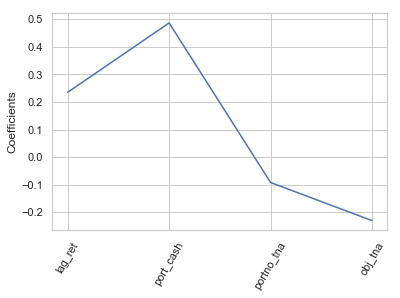

In [42]:
l_params = {'alpha':[.01, .1, .5, 1, 10],'max_iter':[100,1000,10000]}

lasso = linear_model.Lasso(random_state = 123)
clf = GridSearchCV(lasso,l_params,cv=5)
clf.fit(ftrain_features, y_train['flow'].values)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(ftest_features,y_test['flow'].values))

#best_model = clf.best_estimator_
y_pred = best_model.predict(ftest_features)
best_model.score(ftest_features,y_test)

print('\n',list(zip(best_model.coef_,ftest_features)))

lasso_coefs = best_model.coef_
_ = plt.plot(range(len(ftest_features.columns)), lasso_coefs)
_ = plt.xticks(range(len(ftest_features.columns)), ftest_features.columns, rotation = 60)
_ = plt.ylabel('Coefficients')
plt.show()

I examine the results through a random forest regressor next to determine if this model type improves my accuracy. I will check various hyper-parameter values for n_estimators, max_features, and max_depth. There is a trade-off between time to run and accuracy.

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#max depth of tree (until pure or n=1)
#max features (sqrt(n))

grid_parameters = {'n_estimators':[50,100],'max_features':[2,3],'max_depth':[25,50]}

RFR = RandomForestRegressor(random_state=123)
clf = GridSearchCV(RFR, grid_parameters, cv = 3)
clf.fit(Xtrain_scaled,y_train['flow'].values)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xtest_scaled,y_test['flow'].values))
imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = Xtest_scaled.columns
imp_feat


Grid scores for all models based on CV:

0.01599 (+/-0.01095) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 50}
0.02468 (+/-0.00766) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 100}
0.01237 (+/-0.00771) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 50}
0.02082 (+/-0.00862) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 100}
0.01268 (+/-0.00869) for {'max_depth': 50, 'max_features': 2, 'n_estimators': 50}
0.02250 (+/-0.00672) for {'max_depth': 50, 'max_features': 2, 'n_estimators': 100}
0.00755 (+/-0.00789) for {'max_depth': 50, 'max_features': 3, 'n_estimators': 50}
0.01897 (+/-0.00736) for {'max_depth': 50, 'max_features': 3, 'n_estimators': 100}

Best parameters set found on train: {'max_depth': 25, 'max_features': 2, 'n_estimators': 100}

Best model validation accuracy: 0.024684189252455746

Best Mode: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease

,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,0.2165,0.1626,0.1493,0.1941,0.1411,0.1364


In [44]:
from sklearn.externals import joblib

filename = 'finalized_RFR.sav'
joblib.dump(best_model, filename)

['finalized_RFR.sav']

In [45]:
from sklearn.externals import joblib

filename = 'finalized_RFR.sav'
loaded_model = joblib.load(filename)
result = loaded_model.score(Xtest_scaled,y_test)
print('Score for best model:',result,'\n')

feature_importances = pd.DataFrame(loaded_model.feature_importances_,
                                   index = Xtrain_scaled.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances["Std"] = np.std([tree.feature_importances_
                            for tree in loaded_model.estimators_], axis=0)
feature_importances

Score for best model: 0.03973717659836884 



,importance,Std
lag_ret,0.2165,0.0135
portno_tna,0.1941,0.0134
port_cash,0.1626,0.0112
port_exp,0.1493,0.0134
obj_tna,0.1411,0.0120
lag_obj_ret,0.1364,0.0108


B. Classification - I will create an identifier variable that takes on a value of one if a mutual fund earns inflows in the top 5% of funds in a month. 
    1. RandomForest
    2. Gradient Boosted
C. Dimension Reduction with PCA?

I create an indicator variable for use in predicition that identifies the top 20% of flow getting mutual funds from the monthly rankings created earlier. There are 20 ranks ranging from 0 to 19.

In [46]:
flow3['top_flow'] = (flow3['ranks'] >= 16).astype(int)
yc = flow3['top_flow']

I am trying a random forest classifier to see how my 6 variables help determine which mutual funds will experience inflows in the top 20% over the subsequent month. I am recreating my train_test_split files because the new test file will contain the indicator variable 'top_flow' rather than the continuous variable flow. This could have been accomplished all in one step with test retaining two variables and keeping only the necessary one for the respective models, but I was unaware that the regression model would produce such low Rsq values, resulting in my attempts at classification.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_full,yc,test_size=.3,random_state=321)

Xctrain_scaled = pd.DataFrame(scaler.fit_transform(Xc_train.drop(['obj','ym'],axis=1)),
                        columns=['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret'])
ctrain_dum_vars = Xc_train[['obj','ym']]
Xctrain_con = pd.concat([Xctrain_scaled.reset_index(drop=True), ctrain_dum_vars.reset_index(drop=True)], axis=1)
Xctrain_con_d = pd.get_dummies(Xctrain_con, columns=['ym','obj'])

Xctest_scaled = pd.DataFrame(scaler.transform(Xc_test.drop(['obj','ym'],axis=1)),
                        columns=['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret'])
ctest_dum_vars = Xc_test[['obj','ym']]
Xctest_con = pd.concat([Xctest_scaled.reset_index(drop=True), ctest_dum_vars.reset_index(drop=True)], axis=1)
Xctest_con_d = pd.get_dummies(Xctest_con, columns=['ym','obj'])

grid_parameters = {'n_estimators':[50,100],'max_features':[2,3,4],'max_depth':[25,50]}

RFC = RandomForestClassifier(random_state=123)
clf = GridSearchCV(RFC, grid_parameters, cv = 3)
clf.fit(Xctrain_scaled,yc_train)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xctest_scaled,yc_test))

imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = Xtest_scaled.columns
imp_feat

Grid scores for all models based on CV:

0.97010 (+/-0.00184) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 50}
0.97119 (+/-0.00150) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 100}
0.98201 (+/-0.00087) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 50}
0.98245 (+/-0.00054) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 100}
0.98522 (+/-0.00047) for {'max_depth': 25, 'max_features': 4, 'n_estimators': 50}
0.98549 (+/-0.00070) for {'max_depth': 25, 'max_features': 4, 'n_estimators': 100}
0.97039 (+/-0.00187) for {'max_depth': 50, 'max_features': 2, 'n_estimators': 50}
0.97176 (+/-0.00071) for {'max_depth': 50, 'max_features': 2, 'n_estimators': 100}
0.98185 (+/-0.00101) for {'max_depth': 50, 'max_features': 3, 'n_estimators': 50}
0.98261 (+/-0.00093) for {'max_depth': 50, 'max_features': 3, 'n_estimators': 100}
0.98510 (+/-0.00078) for {'max_depth': 50, 'max_features': 4, 'n_estimators': 50}
0.98546 (+/-0.00052) for {'max_depth': 50, 'max_feat

,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,0.3597,0.0199,0.0165,0.0158,0.2344,0.3537


In [58]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear')

grid_lr = {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10]}

clf = GridSearchCV(lr,grid_lr,cv=3)
clf.fit(Xctrain_scaled,yc_train)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xctest_scaled,yc_test))

lr_results = pd.DataFrame(best_model.coef_.tolist(),columns=Xctest_scaled.columns)
lr_results[['lag_ret','port_cash','port_exp','portno_tna','obj_tna','lag_obj_ret']]

Grid scores for all models based on CV:

0.86040 (+/-0.00155) for {'C': 0.001, 'penalty': 'l1'}
0.84870 (+/-0.00132) for {'C': 0.001, 'penalty': 'l2'}
0.86528 (+/-0.00132) for {'C': 0.01, 'penalty': 'l1'}
0.86342 (+/-0.00141) for {'C': 0.01, 'penalty': 'l2'}
0.86573 (+/-0.00131) for {'C': 0.1, 'penalty': 'l1'}
0.86548 (+/-0.00130) for {'C': 0.1, 'penalty': 'l2'}
0.86578 (+/-0.00126) for {'C': 1, 'penalty': 'l1'}
0.86576 (+/-0.00128) for {'C': 1, 'penalty': 'l2'}
0.86577 (+/-0.00127) for {'C': 10, 'penalty': 'l1'}
0.86577 (+/-0.00127) for {'C': 10, 'penalty': 'l2'}

Best parameters set found on train: {'C': 1, 'penalty': 'l1'}

Best model validation accuracy: 0.8657755372570018

Best Mode: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Best Score: 0.8652973950318193


,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,6.3035,-0.0067,0.0492,-0.0210,-0.3182,-4.6477


In [59]:
from sklearn.ensemble import GradientBoostingClassifier

grid_parameters = {'n_estimators':[50,100,150],'max_features':[2,3,4],'max_depth':[25,50]}

GBC = GradientBoostingClassifier(random_state=123)
clf = GridSearchCV(RFC, grid_parameters, cv = 3)
%time clf.fit(Xctrain_scaled,yc_train)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xctest_scaled,yc_test))

imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = Xctest_scaled.columns
imp_feat

Wall time: 51min 42s
Grid scores for all models based on CV:

0.97010 (+/-0.00184) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 50}
0.97119 (+/-0.00150) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 100}
0.97133 (+/-0.00122) for {'max_depth': 25, 'max_features': 2, 'n_estimators': 150}
0.98201 (+/-0.00087) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 50}
0.98245 (+/-0.00054) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 100}
0.98249 (+/-0.00065) for {'max_depth': 25, 'max_features': 3, 'n_estimators': 150}
0.98522 (+/-0.00047) for {'max_depth': 25, 'max_features': 4, 'n_estimators': 50}
0.98549 (+/-0.00070) for {'max_depth': 25, 'max_features': 4, 'n_estimators': 100}
0.98561 (+/-0.00076) for {'max_depth': 25, 'max_features': 4, 'n_estimators': 150}
0.97039 (+/-0.00187) for {'max_depth': 50, 'max_features': 2, 'n_estimators': 50}
0.97176 (+/-0.00071) for {'max_depth': 50, 'max_features': 2, 'n_estimators': 100}
0.97198 (+/-0.00051) for {'ma

,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,0.3625,0.0201,0.0166,0.0163,0.2347,0.3497


In [60]:
from xgboost import XGBClassifier

grid_parameters = {'n_estimators':[50,100,150],'max_depth':[25,50]}

xgb = XGBClassifier(random_state = 123)
clf = GridSearchCV(xgb, grid_parameters, cv = 3)
%time clf.fit(Xctrain_scaled,yc_train)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xctest_scaled,yc_test))

imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = Xctest_scaled.columns
imp_feat

Wall time: 23min 57s
Grid scores for all models based on CV:

0.98871 (+/-0.00081) for {'max_depth': 25, 'n_estimators': 50}
0.99021 (+/-0.00051) for {'max_depth': 25, 'n_estimators': 100}
0.99072 (+/-0.00031) for {'max_depth': 25, 'n_estimators': 150}
0.98892 (+/-0.00087) for {'max_depth': 50, 'n_estimators': 50}
0.99048 (+/-0.00055) for {'max_depth': 50, 'n_estimators': 100}
0.99093 (+/-0.00022) for {'max_depth': 50, 'n_estimators': 150}

Best parameters set found on train: {'max_depth': 50, 'n_estimators': 150}

Best model validation accuracy: 0.9909276321947164

Best Mode: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Best Score: 0.9935802694

,lag_ret,port_cash,port_exp,portno_tna,obj_tna,lag_obj_ret
0,0.1966,0.0663,0.0649,0.0673,0.3245,0.2805


Although PCA is not necessary with just 6 features, I am employing PCA to explore the impact on my results.

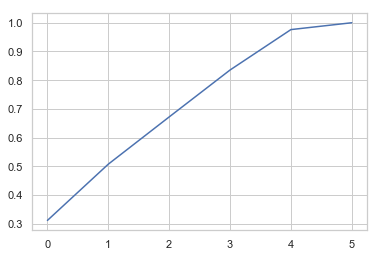

In [61]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 123)

pca.fit_transform(Xctrain_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [62]:
pca = PCA(n_components = 5, random_state = 123)

Xc_train_pca3 = pd.DataFrame(pca.fit_transform(Xctrain_scaled),columns=[['x1','x2','x3','x4','x5']])

Xc_test_pca3 = pd.DataFrame(pca.transform(Xctest_scaled),columns=[['x1','x2','x3','x4','x5']])

In [63]:
from xgboost import XGBClassifier

grid_parameters = {'n_estimators':[50,100,150],'max_depth':[25,50]}

xgb = XGBClassifier(random_state = 123)
clf = GridSearchCV(xgb, grid_parameters, cv = 3)
%time clf.fit(Xc_train_pca3,yc_train)

print('Grid scores for all models based on CV:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
print('\nBest parameters set found on train:', clf.best_params_)
print('\nBest model validation accuracy:', clf.best_score_)

best_model = clf.best_estimator_

print('\nBest Mode:',best_model)
print('\nBest Score:',best_model.score(Xc_test_pca3,yc_test))

imp_feat = pd.DataFrame(best_model.feature_importances_).transpose()
imp_feat.columns = Xc_test_pca3.columns
imp_feat

Wall time: 33min 21s
Grid scores for all models based on CV:

0.84954 (+/-0.00089) for {'max_depth': 25, 'n_estimators': 50}
0.84949 (+/-0.00092) for {'max_depth': 25, 'n_estimators': 100}
0.84933 (+/-0.00101) for {'max_depth': 25, 'n_estimators': 150}
0.84895 (+/-0.00063) for {'max_depth': 50, 'n_estimators': 50}
0.84880 (+/-0.00040) for {'max_depth': 50, 'n_estimators': 100}
0.84880 (+/-0.00051) for {'max_depth': 50, 'n_estimators': 150}

Best parameters set found on train: {'max_depth': 25, 'n_estimators': 50}

Best model validation accuracy: 0.8495419194326723

Best Mode: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Best Score: 0.856033480113

,x1,x2,x3,x4,x5
0,0.2289,0.2149,0.1674,0.1591,0.2298


# Summary of results

The results presented throughout this document are consistent with those originally outlined by Sirri and Tufano (1998). This original paper showed how investors chase prior returns, resulting in the best performing mutual funds over the prior period earning the highest returns over the subsequent period. Furthermore, they detail a non-linear relationship, where the majority of the benefit is experienced by the top performing mutual funds.

To examine this relationship I employ two sets of tests. First, I utilize regression to explain the amount of fund flows a mutual fund experiences. Second, I utilize a prediction to determine if a mutual fund will earn fund inflows in the top 20% of all funds during a given period. 

### Regression

I first look at utilizing a linear regression approach to get a general sense of the relationship each variable has with mutual fund flow. I start with unscaled variables and then move to scaled variables with a mean = 0 and standard deviation = 1 to allow for a better understanding of how important each feature is. I next utilize a lasso regression and then a lasso regression with recursive feature elimination (reducing from 6 features to 4). Finally, I utilize a Random Forest Regressor approach. Overall, prior period returns prove to be a strong indicator of future fund flows. Within the lasso regression approach I observe cash holdings as a strong predictor of future fund flows, though the economic interpretation of why this would matter is unclear. There is no rationale behind the observed relation with cash. Though the regression approach yields very low R-squared values, the relationships observed throughout are consistent with investors chasing prior returns.

### Prediction

Moving from regression to prediction yields far stronger results, though interpretation of which features drive the relationship are no statistically testable, feature importance still provides some insight. I begin with a Random Forest Classification, then logistic regression, followed by two versions of a Gradient Boosting Classification, and I finish with PCA to reduce my number of features for use in another Gradient Boosting Classification. Overall the results excellent, with over 85% accuracy. Though the ability to identify which mutual funds will each the greatest future fund flows is valuable, the results vary across model when looking at feature importance. However, past returns do show up as either the most important or one of the most important features across all models. This is consistent with ex-ante expectations and supports the findings of Sirri and Tufano (1999) with much more up-to-date modeling techniques.

### Final Comments

This project confirmed by prior expectation that investors chase prior returns. I was impressed by the accuracy in which the prediction models were able to determine which mutual funds would earn fund flows within the top 20% of observations. In my field understanding the why is just as important as obtaining a result. For that reason, I think that the approach above best suited to my needs would be one of the methods utilized in the regression analysis even though the overall performance of these is lower.

In [64]:
def make_xy(in_file, y_name):
        
    y = in_file[[y_name]]
    X = in_file.drop([y_name],axis=1)

    return X, y
X, y = make_xy(flow3,'flow')

In [65]:
import pandas as pd

flow3_d = pd.get_dummies(flow3['ym'])
flow4 = pd.concat([flow3, flow3_d],axis=1,join_axes=[flow3.index])



In [66]:
#standardize variables to mean = 0 , std = 1

